In [34]:
# Libraries used for analysis 

import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go

In [35]:
# Files upload 

rest = pd.read_csv("FOOD_CATEGORY_restaurants_output.csv")
menus = pd.read_csv("FOOD_CATEGORY_restaurant_menus_output.csv")

In [36]:
# Number of restaurants in menus file
unique_rest = menus["restaurant_id"].nunique()

print(unique_rest)

550


In [37]:
# Unique categories in menus
unique_categories = menus["category"].value_counts()

print(unique_categories)

Sides                    2253
Picked for you           2231
Drinks                   1839
Tacos                    1426
Burritos                 1391
                         ... 
Champaing Sparkling         1
Premium Margarita Bar       1
Chophouse                   1
Community Kitchen.          1
House Made Drinks           1
Name: category, Length: 1570, dtype: int64


In [38]:
# Unique meals in menus

unique_meal = menus["name"].value_counts()

print((unique_meal).head(10))

Guacamole                       203
Quesadilla                      163
Cheese Quesadilla               146
Nachos                          122
Burrito                         121
Cinnamon Twists                 120
Chips and Salsa                  98
Chicken Quesadilla               96
Black Beans                      95
Chips and Nacho Cheese Sauce     95
Name: name, dtype: int64


In [39]:
# Remove the "USD" string and convert the 'price' column to a numeric data type
menus['price'] = menus['price'].str.replace(' USD', '').astype(float)

In [40]:
# Merge two data sets
merged_data = rest.merge(menus, left_on="rm_restaurant_id", right_on="restaurant_id")

In [59]:
# Change the name of cities in the state_city column
def format_city_name(state_city):
    state, city = state_city.split('/')
    formatted_city = ' '.join(word.capitalize() for word in city.split(' '))
    return f"{state}/{formatted_city}"

merged_data['state_city'] = merged_data['state_city'].apply(format_city_name)


In [60]:
top_10_prices = merged_data["price"].nlargest(10)

print(top_10_prices)

19962    286.00
19961    214.50
19960    143.00
3869     140.00
18217    130.00
16632    126.50
16637    121.00
21161    120.00
17130    111.92
17136    111.92
Name: price, dtype: float64


In [61]:
meals_in_all_cities = merged_data.groupby('name')['state_city'].nunique()

print(meals_in_all_cities)

name
  Burrito.with carne asada    1
  Taco Cochinita Pibil        1
 Add Sour Cream               1
 Amarillo.*                   1
 Arrachera                    1
                             ..
wario lopez                   1
white Rice                    1
whole Chicken (halal)         1
yuca.                         1
À la Carte                    1
Name: state_city, Length: 15123, dtype: int64


In [62]:
# Find meals present in all cities
unique_cities = merged_data['state_city'].nunique()
meals_in_all_cities = merged_data.groupby('name')['state_city'].nunique()
meals_in_all_cities = meals_in_all_cities[meals_in_all_cities == unique_cities].index.tolist()

# Exclude Black Beans and Sour Cream from the list
excluded_meals = ['Black Beans', 'Sour Cream', 'Rice', 'Bottled Water', 'Beans', 'Chips', 'Horchata']
meals_in_all_cities = [meal for meal in meals_in_all_cities if meal not in excluded_meals]

# Filter data only for meals in all cities
meals_all_cities = merged_data[merged_data['name'].isin(meals_in_all_cities)]

# Find the 10 most popular meals from the menus which are present in all cities
popular_meals = meals_all_cities['name'].value_counts().nlargest(10).index.tolist()

# Filter data only for the most popular meals
most_popular_meals = merged_data[merged_data['name'].isin(popular_meals)]

# Check the avg prices for those dishes in each city
most_popular_meals_prices = most_popular_meals.groupby(['state_city', 'name'])['price'].mean().reset_index()

# Round the mean price to 2 decimal places
most_popular_meals_prices['price_mean'] = most_popular_meals_prices['price'].round(2)
most_popular_meals_prices.drop(columns='price', inplace=True)

# Results and comments
print(most_popular_meals_prices)


       state_city                name  price_mean
0   AL/Birmingham             Burrito        4.08
1   AL/Birmingham         Carne Asada       16.27
2   AL/Birmingham   Cheese Quesadilla        6.80
3   AL/Birmingham  Chicken Quesadilla        6.27
4   AL/Birmingham                Flan        5.72
..            ...                 ...         ...
75   WI/Milwaukee           Guacamole        5.12
76   WI/Milwaukee              Nachos        9.11
77   WI/Milwaukee          Quesadilla        8.93
78   WI/Milwaukee          Taco Salad       11.66
79   WI/Milwaukee               Tacos        3.04

[80 rows x 3 columns]


In [63]:
# Check number of unique names of the meals in the most_popular_meals_prices data frame
unique_meal_names = most_popular_meals_prices['name'].unique()
num_unique_meals = len(unique_meal_names)
print(f"Number of unique meals in most_popular_meals_prices: {num_unique_meals}")


Number of unique meals in most_popular_meals_prices: 10


In [64]:
# Check if we have 10 meals for every city
all_meals = set(most_popular_meals['name'].unique())
for state_city, city_data in most_popular_meals_prices.groupby("state_city"):
    city_meals = set(city_data['name'].unique())
    missing_meals = all_meals - city_meals
    print(f"In {state_city}, {len(city_meals)} meals are present. Missing meals: {missing_meals}")

In AL/Birmingham, 10 meals are present. Missing meals: set()
In DC/Washington Dc, 10 meals are present. Missing meals: set()
In OR/Portland, 10 meals are present. Missing meals: set()
In TX/Austin, 10 meals are present. Missing meals: set()
In UT/Salt Lake City, 10 meals are present. Missing meals: set()
In VA/Arlington, 10 meals are present. Missing meals: set()
In WA/Spokane, 10 meals are present. Missing meals: set()
In WI/Milwaukee, 10 meals are present. Missing meals: set()


In [65]:
# Create an interactive bar plot using Plotly
fig = px.bar(most_popular_meals_prices, x='state_city', y='price_mean', color='name', barmode='group', text='price_mean',
             title='Average Prices of 10 Most Popular Menu Selections', labels={'state_city': 'City', 'price_mean': 'Average Price'})

# Update the layout for better readability
fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': most_popular_meals_prices['state_city'].unique()})
fig.update_traces(texttemplate='%{text:.2f}', textposition='inside')
fig.update_yaxes(title='Average Price', tickprefix='$')

# Show the plot
fig.show()

In [66]:
# Save the interactive plot as an HTML file
pio.write_html(fig, file="most_popular_meals_prices.html", auto_open=True)

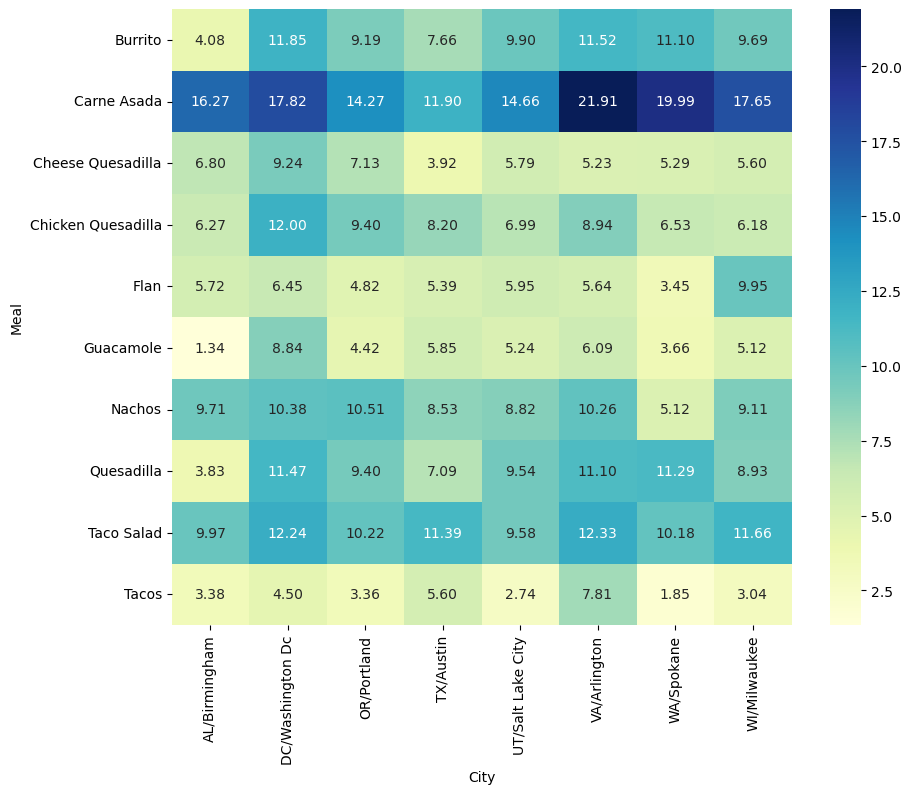

In [67]:
# Pivot the data frame to create a new data frame with cities as columns and meals as rows
meal_prices_pivot = most_popular_meals_prices.pivot_table(index='name', columns='state_city', values='price_mean')

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(meal_prices_pivot, cmap='YlGnBu', annot=True, fmt='.2f')
plt.xlabel('City')
plt.ylabel('Meal')
plt.show()
